<a href="https://colab.research.google.com/github/rubenIng93/MLDL-HW2/blob/master/Homework2_MLDL_Berteletti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Install requirements**

In [ ]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

     |██████████████████████          | 506.2MB 2.2MB/s eta 0:01:45ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/urllib3/response.py", line 425, in _error_catcher
    yield
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/urllib3/response.py", line 507, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/cachecontrol/filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "/usr/lib/python3.6/http/client.py", line 459, in read
    n = self.readinto(b)
  File "/usr/lib/python3.6/http/client.py", line 503, in readinto
    n = self.fp.readinto(b)
  File "/usr/lib/python3.6/socket.py", line 586, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.6/ssl.py", line 1012, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3.6/ssl.py", line 874, in read
    return self._sslobj.read(len, buffer)

**Import libraries**

In [1]:
import os
import logging
import sys
import numpy as np
import time
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision.datasets import VisionDataset
from torchvision import transforms
from torchvision.models import alexnet, vgg19

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [124]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-4            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 50       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [3]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]) # Normalizes tensor with mean and standard deviation
])

# first set data augmentation
train_transform_augmentation1 = transforms.Compose([transforms.Resize(256),      
                                      transforms.CenterCrop(224),  
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.RandomRotation(120),
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225]) # Normalizes tensor with mean and standard deviation
                                                    
])

# second set data augmentation
train_transform_augmentation2 = transforms.Compose([transforms.Resize(256),      
                                      transforms.CenterCrop(224),  
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225]) # Normalizes tensor with mean and standard deviation
                                                    
])

# third set data augmentation
train_transform_augmentation3 = transforms.Compose([transforms.Resize(256),      
                                      transforms.CenterCrop(224),  
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225]) # Normalizes tensor with mean and standard deviation
                                                    
])


# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])                                    
])

In [4]:
# Lazy dataset class used for avoid in the validation set 
# the data augmentation transformations

class MapDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(self.dataset)

**Prepare Dataset**

In [97]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/rubenIng93/Homework2-Caltech101
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train')
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

# applying the lazy dataset
#train = MapDataset(train_dataset, transform=train_transform)
#train = MapDataset(train_dataset, transform=train_transform_augmentation1)
train = MapDataset(train_dataset, transform=train_transform_augmentation2)
#train = MapDataset(train_dataset, transform=train_transform_augmentation3)
validation = MapDataset(train_dataset, transform=eval_transform)

# It uses the Stratified split method
train_idx, val_idx = train_dataset.train_val_split(0.5)

train_dataset = Subset(train, train_idx)
val_dataset = Subset(validation, val_idx)


# Check dataset sizes
print('Train Dataset: {}'.format(train_dataset.__len__()))
print('Valid Dataset: {}'.format(val_dataset.__len__()))
print('Test Dataset: {}'.format(test_dataset.__len__()))

Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


**Prepare Dataloaders**

In [120]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Look at the Images**

In [7]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0) 
  image = image * np.array((0.5, 0.5, 0.5) + np.array((0.5, 0.5, 0.5)))
  image = image.clip(0, 1)
  return image

In [8]:
classes = []

for label in os.listdir('Caltech101/101_ObjectCategories'):
  if label.find('BACK') < 0:
    classes.append(label)

classes.sort()
print('Num Classes:', len(classes))

Num Classes: 101


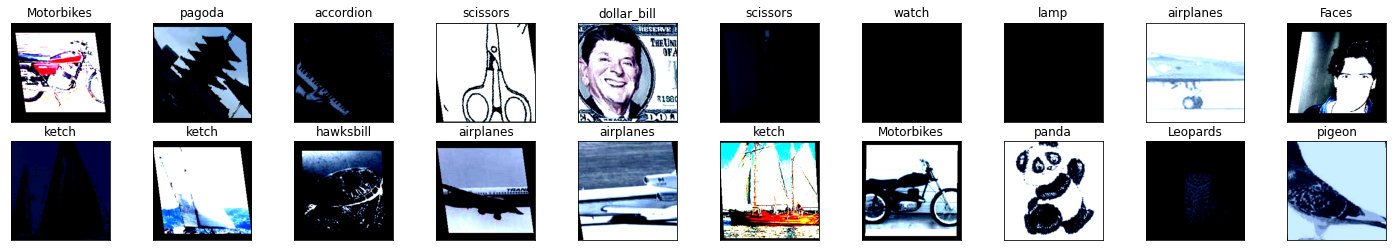

In [107]:
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx]])

**Prepare Network**

In [10]:
# change the last FC layer in order to predict 101 classes
# and freezing the parameters if required
def change_last_layer(net, position, freeze=None, print_schema=True):
  # freeze all the layer aimed to the feature extraction
  # so keep only the fully connected layers
  if freeze == 'features':
    for param in net.features.parameters(): 
      param.requires_grad = False

  # if freeze is an integer freeze from there to the first layer
  if isinstance(freeze, int):
    for i, param in enumerate(pretrained_net.features.parameters()):
      if i <= freeze:
        param.requires_grad = False
      i += 1   

  # freeze only the fully connected layers
  if freeze == 'classifier':
    for param in net.classifier.parameters():
      param.requires_grad = False
      
  # change the last fully connected layer in order to 
  # match the number of classes for the classification problem
  n_inputs = net.classifier[position].in_features
  last_layer = nn.Linear(n_inputs, len(classes))
  net.classifier[position] = last_layer
  net.to(DEVICE)
  if print_schema == True:
    print(net)

In [79]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
#net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code
change_last_layer(net, 6, print_schema=False)

**Pretrained Model**

In [125]:
# Pretrained model
pretrained_net = alexnet(pretrained=True)
change_last_layer(pretrained_net, 6,  print_schema=False)

**VGG19**

In [ ]:
vgg = vgg19(pretrained=True)
change_last_layer(vgg, 6, freeze='fc', print=False)

**Prepare Training**

In [126]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 

#parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
parameters_to_optimize = pretrained_net.parameters()
#parameters_to_optimize = vgg.parameters()


# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
#optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
optimizer = optim.Adam(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**My Training and Validation**

In [ ]:
start = time.time()

#net = vgg.to(DEVICE)
net = pretrained_net.to(DEVICE)
#net = net.to(DEVICE)

running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(NUM_EPOCHS):

  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0


  for inputs, labels in train_dataloader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train()
    outputs = net(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in val_dataloader:
        net.train(False)
        val_inputs = val_inputs.to(DEVICE)
        val_labels = val_labels.to(DEVICE)
        val_outputs = net(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)



    epoch_loss = running_loss/len(train_dataloader.dataset)
    epoch_acc = running_corrects.float()/len(train_dataloader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(val_dataloader.dataset)
    val_epoch_acc = val_running_corrects.float()/len(val_dataloader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('epoch: {}/{}, LR={}'.format(e+1, NUM_EPOCHS, scheduler.get_last_lr()))
    print('training loss: {:.4f},  training accuracy {:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation accuracy {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

  scheduler.step()

print("--- %s minutes ---" % (float(time.time() - start)/60))

In [17]:
def get_graph(title, loss=True):
  if loss == True:
    # loss
    fig = go.Figure()

    fig.add_trace(go.Scatter(y=running_loss_history,
                        mode='lines+markers',
                        name='Training loss'))
    fig.add_trace(go.Scatter(y=val_running_loss_history,
                        mode='lines+markers',
                        name='Validation loss'))

    fig.update_layout(title=title,
                      legend=dict(
                      yanchor="top",
                      y=0.99,
                      xanchor="right",
                      x=0.99
                      ),
                      width=600, height=400,
                      xaxis_title="epoch",
                      yaxis_title="loss",
                      )
    
    
    fig.update_yaxes(nticks=12)
    fig.update_xaxes(nticks=10)

    fig.show()
  else:
    # accuracy
    train, val = [], []
    for t, v in zip(running_corrects_history, val_running_corrects_history):
      t = t.detach().cpu().clone().numpy()
      v = v.detach().cpu().clone().numpy()
      train.append(t)
      val.append(v)

    fig = go.Figure()

    fig.add_trace(go.Scatter(y=train,
                        mode='lines+markers',
                        name='Training accuracy'))
    fig.add_trace(go.Scatter(y=val,
                        mode='lines+markers',
                        name='Validation accuracy'))

    fig.update_layout(title=title,
                      legend=dict(
                      yanchor="bottom",
                      y=0.05,
                      xanchor="right",
                      x=0.99
                      ),
                      width=600, height=400,
                      xaxis_title="epoch",
                      yaxis_title="accuracy",)
    
    fig.update_yaxes(nticks=12)
    fig.update_xaxes(nticks=10)

    fig.show()



In [105]:
get_graph("Loss vs epochs - Alexnet pretrained Adam aug2 LR="+str(LR))

In [106]:
get_graph("Accuracy vs epochs - Alexnet Adam aug2 LR="+str(LR), loss=False)

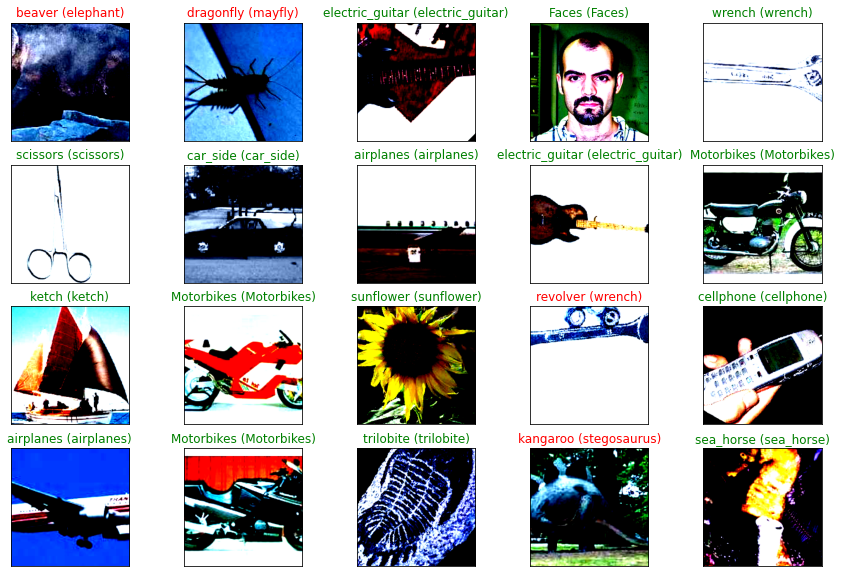

In [40]:
# checking the predictions in the validation set
dataiter = iter(val_dataloader)
images, labels = dataiter.next()
images = images.to(DEVICE)
labels = labels.to(DEVICE)
output = net(images)
_, preds = torch.max(output, 1)


fig = plt.figure(figsize=(15, 10))

for idx in np.arange(20):
  ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), \
                              color=("green" if preds[idx]==labels[idx] else "red"))

**Test**

In [118]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 58/58 [00:08<00:00,  6.67it/s]

Test Accuracy: 0.8423781541652264
